# Physics-Informed Neural Network (PINN) in Julia

This is a simple example in using regression with neural networks

We shall try to fit a given function with the neural network.
For instance $f(x) = \sin(2\pi x k)$.

This can be done by chosing collocation points, i.e., random points within the domain at which we enfore the loss function. A difference of the neural network against this underlying description will constitute to the loss. 



In [1]:
using Optimisers, Zygote, Plots, Random, Distributions
#, OptimizationOptimJL

In [2]:
SEED = 42
N_collocation_points = 50
HIDDEN_DEPTH = 100
LEARNING_RATE = 1e-3
N_EPOCHS = 40_000

40000

In [3]:
k = 1
solution(x) = sin(π*k*x)

solution (generic function with 1 method)

In [4]:
rng = MersenneTwister(SEED)

MersenneTwister(42)

In [5]:
sigmoid(x) = 1.0 / (1.0 + exp(-x))

sigmoid (generic function with 1 method)

In [6]:
function initialize_parameters()
    # Initialize the weights according to the Xavier Glorot initializer
    uniform_limit = sqrt(6 / (1 + HIDDEN_DEPTH))
    W = rand(
        rng,
        Uniform(-uniform_limit, +uniform_limit),
        HIDDEN_DEPTH,
        1,
    )
    V = rand(
        rng,
        Uniform(-uniform_limit, +uniform_limit),
        1,
        HIDDEN_DEPTH,
    )
    b = zeros(HIDDEN_DEPTH)
    parameters = (; W, V, b)
    return parameters
end

initialize_parameters (generic function with 1 method)

In [7]:
W, V, b = initialize_parameters()
parameters = (; W, V, b)
methods = [:log10, :direct]


2-element Vector{Symbol}:
 :log10
 :direct

In [8]:
network_forward(x, p) = p.V * sigmoid.(p.W * x .+ p.b)

network_forward (generic function with 1 method)

In [9]:
x_line = reshape(collect(range(0.0, stop=1.0, length=100)), (1, 100))

1×100 Matrix{Float64}:
 0.0  0.010101  0.020202  0.030303  …  0.969697  0.979798  0.989899  1.0

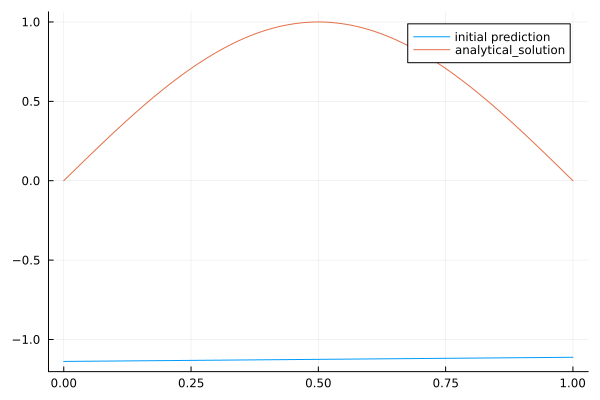

In [10]:
# Plot initial prediction of the network (together with the analytical solution)
plot(x_line[:], network_forward(x_line, parameters)[:], label="initial prediction")
plot!(x_line[:], solution.(x_line[:]), label="analytical_solution")

In [11]:
function network_output(x, p)
    activated_state = sigmoid.(p.W * x .+ p.b)
    output = p.V * activated_state
    return output
end

network_output (generic function with 1 method)

In [12]:
_output = network_output(x_line, parameters)

1×100 Matrix{Float64}:
 -1.13829  -1.13803  -1.13776  -1.1375  …  -1.11266  -1.1124  -1.11213

In [13]:
_zygote_first_derivative = Zygote.gradient(x -> sum(network_forward(x, parameters)), x_line)[1]

1×100 Matrix{Float64}:
 0.0262064  0.0262064  0.0262063  …  0.0260738  0.0260711  0.0260683

In [14]:
interior_collocation_points = rand(rng, Uniform(0.0, 1.0), (1, N_collocation_points))

1×50 Matrix{Float64}:
 0.0357248  0.473918  0.441437  0.841032  …  0.872303  0.680714  0.776496

In [15]:
function loss_forward_direct(p)
    output = network_output(
        interior_collocation_points,
        p,
    )
    sum(abs2.(output - solution.(interior_collocation_points)))/length(output)
end

function loss_forward_log10(p)
    log10(loss_forward_direct(p))
end

loss_forward_log10 (generic function with 1 method)

In [16]:
loss_forward_direct(parameters)

3.214640835226762

In [17]:
out, back = Zygote.pullback(loss_forward_direct, parameters)

(3.214640835226762, Zygote.var"#88#89"{Zygote.Pullback{Tuple{typeof(loss_forward_direct), @NamedTuple{W::Matrix{Float64}, V::Matrix{Float64}, b::Vector{Float64}}}, Tuple{Zygote.Pullback{Tuple{typeof(network_output), Matrix{Float64}, @NamedTuple{W::Matrix{Float64}, V::Matrix{Float64}, b::Vector{Float64}}}, Tuple{Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), Matrix{Float64}}, Tuple{}}, Zygote.ZBack{ChainRules.var"#times_pullback#554"{Matrix{Float64}, Matrix{Float64}}}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.broadcasted), typeof(sigmoid), Matrix{Float64}}, Tuple{Zygote.Pullback{Tuple{typeof(Base.Broadcast.broadcastable), Matrix{Float64}}, Tuple{}}, Zygote.var"#2189#back#307"{Zygote.var"#305#306"{Tuple{Tuple{Nothing, Nothing, Nothing}, Tuple{}}, Zygote.var"#4145#back#1372"{Zygote.var"#bc_fwd_back#1410"{Matrix{ForwardDiff.Dual{Nothing, Float64, 1}}, Tuple{Matrix{Float64}}, Val{1}}}}}, Zygote.var"#2033#back#218"{typeof(identity)}, Zygote.var"#2189#back#307"{Zygote.var"#305#3

In [18]:
back(1.0)[1]

(W = [0.09513119539777079; 0.09543241864334774; … ; -0.030717166035030514; 0.02963463681313291;;], V = [-1.8250124117825464 -1.6563754603603174 … -1.8243966380276242 -1.794294227561256], b = [0.15710138626858944, 0.15773633821127123, 0.19739374832781842, 0.16427781947978923, -0.11218958384192099, 0.01589392242716851, 0.19035692366573403, -0.003995183466970266, 0.09577503431644845, 0.11966052725268721  …  -0.1475179997513601, 0.1300273418643342, 0.056568676142694604, -0.10944595620179215, -0.1764130803011614, 0.1198787926703528, -0.1825493663411145, -0.0866041962311162, -0.05072658505547606, 0.04892866019259751])

In [19]:
opt = Adam(LEARNING_RATE)
#opt = OptimizationOptimJL.BFGS()
#opt = OptimizationOptimJL.SSBroyden()
#res = Optimization.solve(prob, opt; callback, maxiters = 2000)
#phi = discretization.phi

Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8)

In [20]:


function solve(methods)
    W, V, b = initialize_parameters()
    parameters_l = (; W, V, b)
    W, V, b = initialize_parameters()
    parameters_d = (; W, V, b)

    for method in methods
        println("Training with method: $method")

    if method == :direct

        opt_state = Optimisers.setup(opt, parameters_d)
        for i in 1:N_EPOCHS
            loss, back = Zygote.pullback(loss_forward_direct, parameters_d)
            push!(loss_history_direct, log10(loss))
            grad, = back(1.0)
            opt_state, parameters_d = Optimisers.update(opt_state, parameters_d, grad)
            if i % 100 == 0
                println("Epoch: $i, Loss: $(log10(loss))")
            end
        end
    elseif method == :log10
        
        opt_state = Optimisers.setup(opt, parameters)
        for i in 1:N_EPOCHS
            loss, back = Zygote.pullback(loss_forward_log10, parameters_l)
            push!(loss_history_log10, loss)
            grad, = back(1.0)
            opt_state, parameters_l = Optimisers.update(opt_state, parameters_l, grad)
            if i % 100 == 0
                println("Epoch: $i, Loss: $loss")
            end
        end
    end
    end
    return parameters_d, parameters_l
end

#parameters_d = initialize_parameters()
#parameters_l = initialize_parameters()

solve (generic function with 1 method)

In [21]:
loss_history_direct = []
loss_history_log10 = []

k=1


parameters_d, parameters_l = solve(methods)


Training with method: log10
Epoch: 100, Loss: -1.1045196897536758
Epoch: 200, Loss: -1.112646983044457
Epoch: 300, Loss: -1.1142710908150268
Epoch: 400, Loss: -1.1144356364066204
Epoch: 500, Loss: -1.1144562085189658
Epoch: 600, Loss: -1.114470665600563
Epoch: 700, Loss: -1.114485830451332
Epoch: 800, Loss: -1.1145016965375545
Epoch: 900, Loss: -1.1145181053755324
Epoch: 1000, Loss: -1.1145349222471364
Epoch: 1100, Loss: -1.114552037588371
Epoch: 1200, Loss: -1.114569367071386
Epoch: 1300, Loss: -1.1145868524560014
Epoch: 1400, Loss: -1.1146044632188616
Epoch: 1500, Loss: -1.1146221991420822
Epoch: 1600, Loss: -1.1146400942360042
Epoch: 1700, Loss: -1.114658222620074
Epoch: 1800, Loss: -1.1146767073555557
Epoch: 1900, Loss: -1.1146957338141714
Epoch: 2000, Loss: -1.1147155701543427
Epoch: 2100, Loss: -1.1147365991897416
Epoch: 2200, Loss: -1.1147593690099304
Epoch: 2300, Loss: -1.11478467543472
Epoch: 2400, Loss: -1.1148137004583685
Epoch: 2500, Loss: -1.1148482532372728
Epoch: 2600, L

((W = [-0.1767585116518711; -0.1355558976933189; … ; 0.7492720465623834; 0.16390958892258983;;], V = [0.02809291793248975 0.08485881689225959 … 0.17672899659600408 -0.12943920814116305], b = [0.0974413491055621, 0.008135472024148424, -0.00680073402458454, -0.1858626002030107, -0.34974351167497275, -0.5127302440645161, -0.018385335076770908, -0.020520542500030277, -0.040540675353208835, -0.04609266816804818  …  -0.012836129632618019, -0.32146612818111836, -0.08218375616276348, -0.010119736089109465, -0.018354817122519313, -0.10088240984222009, 0.0475238655550385, -0.014913824013463277, 0.26642915012435237, -0.005992352566858013]), (W = [-0.7301756338681306; -0.8182158084871611; … ; -0.7681092028480677; 0.6656885892886186;;], V = [0.18851142612165672 0.2796388079997276 … 0.32428018375500356 -0.260052913263995], b = [0.162350052035567, 0.3068974981521655, 0.2553287774421736, -0.5105550178693061, -0.2980665610077117, -0.19593336366976952, 0.22046807370589133, -0.2621716948428696, 0.0714611

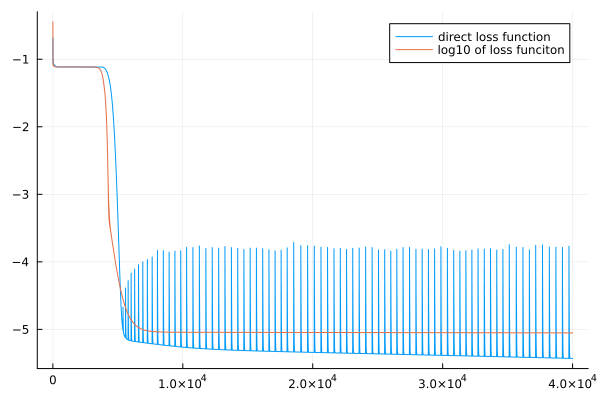

In [22]:
plot(loss_history_direct, label="direct loss function")#, yscale=:log10)
plot!(loss_history_log10, label="log10 of loss funciton")#, yscale=:log10)

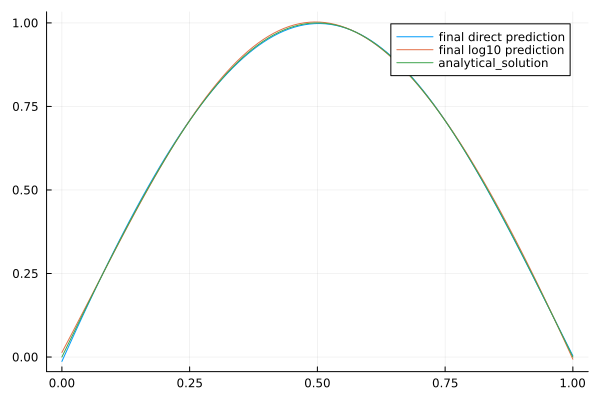

In [23]:
plot(x_line[:], network_forward(x_line, parameters_d)[:], label="final direct prediction")
plot!(x_line[:], network_forward(x_line, parameters_l)[:], label="final log10 prediction")
plot!(x_line[:], solution.(x_line[:]), label="analytical_solution")

In [24]:
k=4

loss_history_direct = []
loss_history_log10 = []

parameters_d, parameters_l = solve(methods)


Training with method: log10
Epoch: 100, Loss: -0.339920307989655
Epoch: 200, Loss: -0.36569336018706766
Epoch: 300, Loss: -0.3813144326684779
Epoch: 400, Loss: -0.38734160245512195
Epoch: 500, Loss: -0.38867559403142565
Epoch: 600, Loss: -0.38885297786399436
Epoch: 700, Loss: -0.3888756951226552
Epoch: 800, Loss: -0.3888863965655064
Epoch: 900, Loss: -0.3888969677169624
Epoch: 1000, Loss: -0.38890800059544
Epoch: 1100, Loss: -0.3889194851056244
Epoch: 1200, Loss: -0.38893140234544266
Epoch: 1300, Loss: -0.3889437454300763
Epoch: 1400, Loss: -0.3889565206068808
Epoch: 1500, Loss: -0.38896974916792887
Epoch: 1600, Loss: -0.3889834710847494
Epoch: 1700, Loss: -0.3889977511747273
Epoch: 1800, Loss: -0.3890126891386029
Epoch: 1900, Loss: -0.3890284357422501
Epoch: 2000, Loss: -0.3890452190928685
Epoch: 2100, Loss: -0.38906338802856705
Epoch: 2200, Loss: -0.3890834853488623
Epoch: 2300, Loss: -0.3891063743425629
Epoch: 2400, Loss: -0.3891334621713513
Epoch: 2500, Loss: -0.3891671002100675
Ep

((W = [-1.3226250260661858; 1.6941583119812496; … ; -1.2494178370014632; -1.384847572345005;;], V = [-0.6988885322073917 0.9446240549909938 … -0.6721370587822447 -0.8563090188681741], b = [0.4959001603862672, -1.3205185526365326, -2.0199252162656847, 0.5025910824159996, -0.5276629315781122, -0.9169611900477574, 0.353310381280306, -0.8551280386554888, 5.975450563360601, -1.2554742927482387  …  2.3703424811262197, 0.012223089692579745, -0.8948629023307705, 0.4365568244399408, -0.9238069776213987, 0.7363141301217054, -9.111945424979712, -0.6642361946916712, 0.0921144725986543, 0.6032854895369054]), (W = [1.1294230477966065; -1.4252393207197416; … ; 5.205007927228215; 1.4999213231231991;;], V = [0.1783669336980714 -1.1292010159292123 … -0.6641440109231946 0.7000872668714491], b = [-0.008016649593949128, 0.16938275159865623, -0.835321652475152, -0.6240905496718229, 0.8050667090747501, 5.155032446286895, -2.2688712956102535, -1.1234101209923428, -0.05750686592183312, -0.9992729360714532  …  

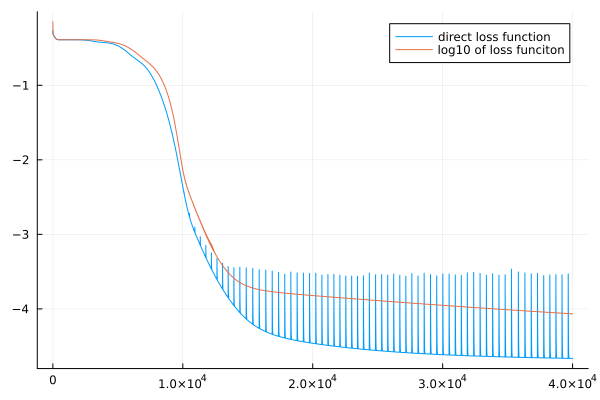

In [25]:
plot(loss_history_direct, label="direct loss function")#, yscale=:log10)
plot!(loss_history_log10, label="log10 of loss funciton")#, yscale=:log10)

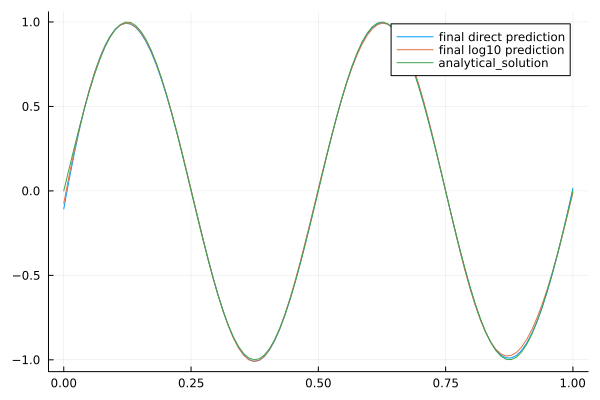

In [26]:
plot(x_line[:], network_forward(x_line, parameters_d)[:], label="final direct prediction")
plot!(x_line[:], network_forward(x_line, parameters_l)[:], label="final log10 prediction")
plot!(x_line[:], solution.(x_line[:]), label="analytical_solution")

In [27]:
k=8

loss_history_direct = []
loss_history_log10 = []

parameters_d, parameters_l = solve(methods)

Training with method: log10
Epoch: 100, Loss: -0.2563766617066332
Epoch: 200, Loss: -0.25638854200587474
Epoch: 300, Loss: -0.25638883997285633
Epoch: 400, Loss: -0.25638921273954934
Epoch: 500, Loss: -0.25638966318106254
Epoch: 600, Loss: -0.25639019794980156
Epoch: 700, Loss: -0.25639082751699344
Epoch: 800, Loss: -0.2563915666898632
Epoch: 900, Loss: -0.2563924357239674
Epoch: 1000, Loss: -0.2563934621294465
Epoch: 1100, Loss: -0.25639468345998706
Epoch: 1200, Loss: -0.25639614625866725
Epoch: 1300, Loss: -0.25639752583640807
Epoch: 1400, Loss: -0.256399118021398
Epoch: 1500, Loss: -0.25640105467290314
Epoch: 1600, Loss: -0.25640345580495005
Epoch: 1700, Loss: -0.25640648885543144
Epoch: 1800, Loss: -0.2564104057363951
Epoch: 1900, Loss: -0.2564146414488037
Epoch: 2000, Loss: -0.25641998171212577
Epoch: 2100, Loss: -0.25642712745361373
Epoch: 2200, Loss: -0.2564370569119662
Epoch: 2300, Loss: -0.2564514629548081
Epoch: 2400, Loss: -0.2564697005642147
Epoch: 2500, Loss: -0.2564991728

((W = [3.561092799490059; 3.0549007924383944; … ; 3.5381360374446804; -3.7030908396003372;;], V = [-1.1720798810874553 -0.9585578264585395 … -1.154105939882024 1.4458995500696528], b = [-1.6030985840325787, -1.2727559113574771, 1.4658781525893165, -1.6006058698214398, 0.9255715049516074, -1.512080339499899, -1.248375511104491, -17.089548533905553, 1.1948112851323032, -1.3868181928566212  …  1.8083372262210287, 2.1252908015809524, 2.948967327392849, -1.5778141223405127, 5.6293178412486835, 0.5063371829703558, -17.301552333721617, -0.3980205068688606, -1.5876044955969142, 1.6982200386963096]), (W = [2.98283520769824; -3.1924609587893045; … ; -3.2501254493303056; 2.120250980698904;;], V = [-1.0087233926000325 1.9190130852881162 … 1.9117382605529043 -0.367452948412788], b = [-1.1180289394040814, 1.264215568964057, -0.5257055966291172, 1.4792086282531978, -0.41404592702205434, -1.2254232972080028, 1.503674794266119, 1.404802664877976, -1.3406878420958854, -1.230671183337486  …  0.3960357319

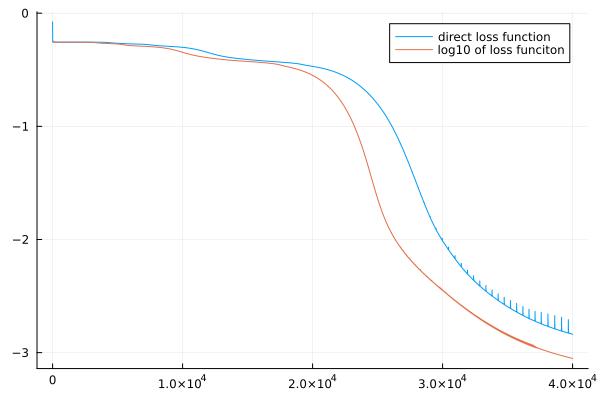

In [28]:
plot(loss_history_direct, label="direct loss function")#, yscale=:log10)
plot!(loss_history_log10, label="log10 of loss funciton")#, yscale=:log10)

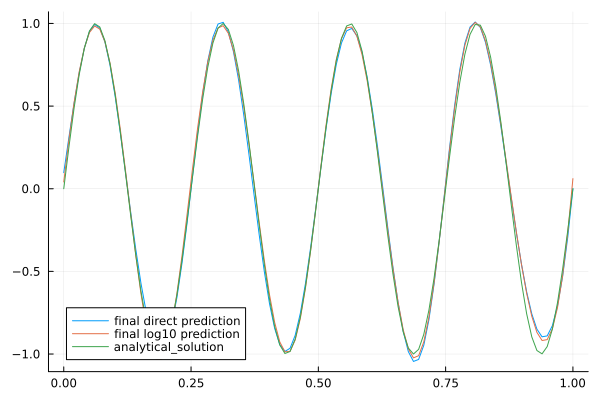

In [30]:
plot(x_line[:], network_forward(x_line, parameters_d)[:], label="final direct prediction")
plot!(x_line[:], network_forward(x_line, parameters_l)[:], label="final log10 prediction")
plot!(x_line[:], solution.(x_line[:]), label="analytical_solution")